In [1]:
using Gen
using Random
using Distributions
using StatsBase: mean, std, quantile
using BenchmarkTools
using FilePathsBase;
using LinearAlgebra: dot, Diagonal
using JSON
import PyPlot
plt = PyPlot.plt

display(HTML("<style>.rendered_html.text_cell_render {max-width:700px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:700px; }</style>")

In [2]:
include("src/utils.jl")
include("src/expo_environment.jl")
include("src/raycaster.jl")

draw_rays! (generic function with 1 method)

# Load Environments

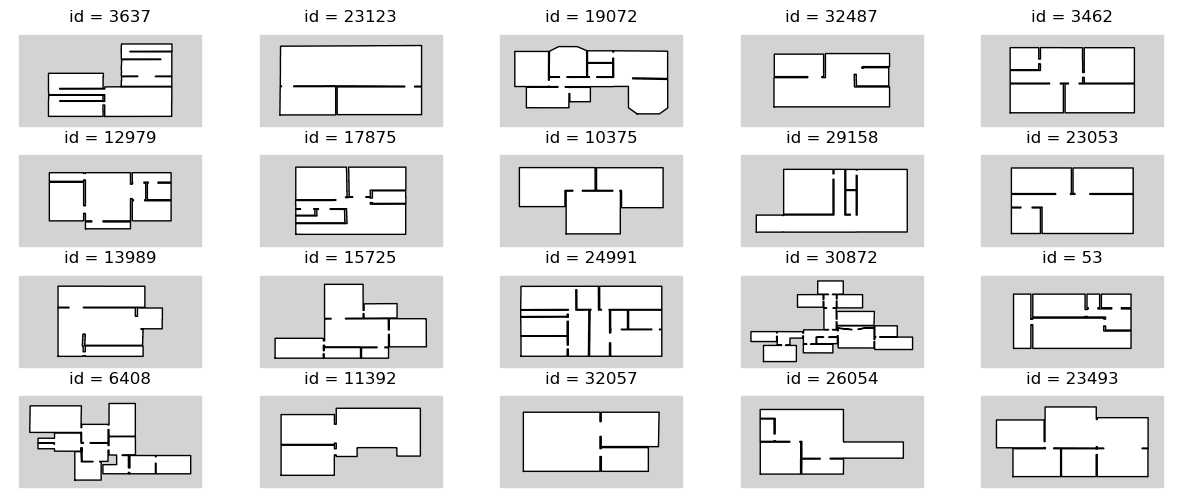

In [3]:
load_random_envs = true

if !load_random_envs
    E = [34596 17505  4322 32640 29165 
          2010 14178 12595 34812  7420 
         31296  9973  4709 14837  6530  
          6923 29392 25033 30415  5046]
else
    E = rand(1:load_env(nothing), 4, 5);
end



fig, axs = plt.subplots(size(E)..., figsize=(15,6));
for I in CartesianIndices(axs)
    i,j = Tuple(I)
    env = load_env(E[i,j]);
    axs[i,j].axis("off")
    draw_env!(env; ax=axs[i,j], title="id = $(E[i,j])")
end

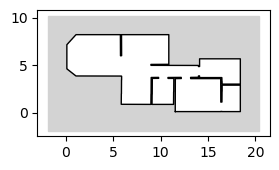

In [4]:
env = load_env(2010);
plt.figure(figsize=(3,3)); plt.gca().set_aspect(1.);
draw_env!(env);

# Pose

In [5]:
"""
    Pose

Encoding the pose of a 2d agent as 
a 2d-position `x` and its head direction `hd`.
"""
struct Pose <: StructIterator
    x::Array{Float64}
    hd::Float64
end

"""
    pose_prior(env)

Samples a pose in the environment. Position
is sampled within the environment bounds and can
potentially land on the outside lawn.
"""
@gen function pose_prior(env::Env)
    x  ~ mvuniform(env.bounds)
    hd ~ uniform(0,2π)
    return Pose(x, hd)
end;

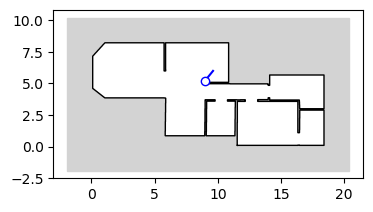

In [6]:
function draw_pose!(pose::Pose; l=1., c="b", ax=plt.gca(), zorder=4)
    x, hd = pose
    v = [cos(hd); sin(hd)]
    y = x + l*v
    ax.scatter(x..., c="w", marker="o", edgecolor=c, zorder=zorder)
    ax.plot([x[1]; y[1]], [x[2]; y[2]], c=c, zorder=zorder-1)
end;

p = pose_prior(env)
# ------------------------
plt.figure(figsize=(4,4)); plt.gca().set_aspect(1.);
draw_env!(env)
draw_pose!(p);

# Sensor model

In [7]:
"""
    Measurement(z,a)

Sensor measurement containing depth values `z` and
the angles `a` of the simulated laser beams.
"""
struct Measurement <: StructIterator
    z::Vector{Float64} # range measurements
    a::Vector{Float64} # angles (pre-noise)
end;


"""
    sensor_model(pose::Pose, env::Env, fov, n, a_noise, z_noise, max_z)

Samples a vector of a pseudo lidar measurement
given a pose in an environment.
"""
@gen function sensor_model(pose::Pose, env::Env, fov, n, a_noise, z_noise, max_z)
    x, hd = pose
    I = Diagonal(ones(n))
        
    a0 = fov == 180 ? angles(fov, n+1)[1:end-1] : angles(fov, n+1)
    
    a = @trace(mvnormal(a0 .+ hd, a_noise*I), :a)

    
    z0 = cast(lightcone(a), x, env.segs; max_val=max_z)
    z  = @trace(mvnormal(z0, z_noise .* I), :z)
    
    return Measurement(z, a0)
end;

In [8]:
function draw_sense!(sense::Measurement, pose::Pose; 
                     ax=plt.gca(), c="C1", alpha=.3, zorder=1, rays=true)

    z, a  = sense
    x, hd = pose

    y = euclidean(z, a .+ hd) .+ x'

    if rays
        for i=1:length(a)
            ax.plot([x[1], y[i,1]],[x[2], y[i,2]], c=c, alpha=0.2, zorder=zorder);
        end
    end
    
    ax.scatter(y[:,1], y[:,2], c=c, alpha=alpha, s=10, zorder=zorder);
    
end;

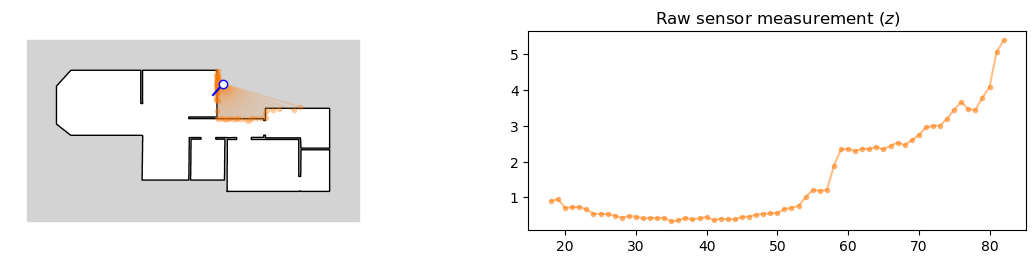

In [9]:
pose = pose_prior(env)
fov = 180
n = 100
sensor_args = (fov, n, 1e-3, 1e-3, Inf)
z,a = sense =  sensor_model(pose, env, sensor_args...)

############
############
fig, axs = plt.subplots(1,2,figsize=(12,3), gridspec_kw=Dict("width_ratios" => [5,4])); 
axs[1].set_aspect(1.);
axs[1].axis("off")
draw_env!(env; ax=axs[1], zorder=0);
draw_pose!(pose; ax=axs[1]);
draw_sense!(sense, pose, ax=axs[1]);
axs[2].set_title("Raw sensor measurement (\$z\$)")
axs[2].plot(z, marker=".", c="C1", alpha=0.5);
plt.tight_layout(2.);

# Naive localization

In [10]:
"""
    sensor_model_with_pose_prior(env, sensor_args)

Combines the sensor model with the pose prior.
"""
@gen function sensor_model_with_pose_prior(env::Env, sensor_args)
    pose  ~ pose_prior(env)
    sense ~ sensor_model(pose, env, sensor_args...)
    
    return pose, sense
end;

In [11]:
function draw_tr!(tr; ax=plt.gca())
    env, sensor_args = get_args(tr)
    pose = tr[:pose]
    sense = tr[:sense]

    draw_env!(env; ax=ax);
    draw_pose!(pose; ax=ax);
    draw_sense!(sense,pose; ax=ax);
end

draw_tr! (generic function with 1 method)

**Creating a ground truth**

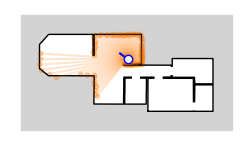

In [31]:
pose = pose_prior(env)
fov = 180
n = 100
sensor_args = (fov, n, 1e-3, 1e-3, 30.)

tr0 = Gen.simulate(sensor_model_with_pose_prior, (env, sensor_args));
obs = choicemap((:sense => :z) => tr0[:sense => :z])

plt.figure(figsize=(3,3)); plt.gca().set_aspect(1.);
plt.gca().axis("off")
draw_tr!(tr0);

**Naive inference**

In [32]:
trs,ws, = Gen.importance_sampling(sensor_model_with_pose_prior, (env, sensor_args), obs, 2000);
perm = sortperm(ws)
trs = trs[perm]
ws = ws[perm]

xs  = hcat([tr[:pose => :x] for tr in trs]...)'
hds = [tr[:pose => :hd] for tr in trs]
vs = hcat(cos.(hds), sin.(hds));

In [33]:
inside = [is_inside(x, env.segs) for x in eachrow(xs)]
xs = xs[inside,:]
hds = hds[inside]
vs = vs[inside,:]
ws = ws[inside];

cm = PyPlot.cm.get_cmap("cool");

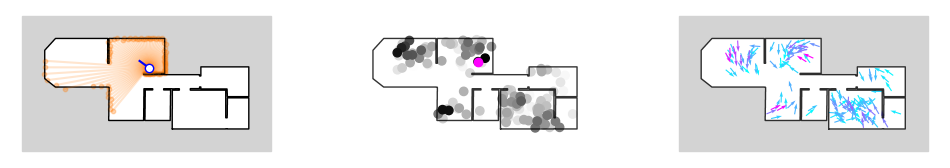

In [34]:
q = quantile(ws, 0.9)

cs = clamp.(ws, q, 0)
cs .-= min(cs...)
cs ./= max(cs...)

xs′ = xs[ws .>= q,:]
vs′ = vs[ws .>= q,:]
cs′ = cs[ws .>= q]

fig, axs = plt.subplots(1,3,figsize=(12,7), gridspec_kw=Dict("width_ratios" => [1,1,1])); 

axs[2].set_aspect(1.); axs[2].axis("off");
draw_env!(env; ax=axs[2], 
    alpha=0.8, zorder=10, wall="black", floor="w", grass="w");
axs[2].scatter(xs′[:,1], xs′[:,2], c=cs′, marker="o", alpha=1., cmap="binary", zorder=2)  
axs[2].scatter(xs[end,:]..., c="magenta", marker="o",  alpha=1., linewidth=1, zorder=3)    

    

axs[3].set_aspect(1.); axs[3].axis("off");
draw_env!(env; ax=axs[3], 
        alpha=0.8, zorder=10, wall="black", floor="w", grass="lightgray");

axs[3].quiver(xs′[:,1],xs′[:,2], vs′[:,1], vs′[:,2], width=.1,
    units="xy", scale_units="xy", scale=1., color=cm.(cs′))  

axs[1].set_aspect(1.)
axs[1].axis("off")
draw_tr!(tr0; ax=axs[1]);


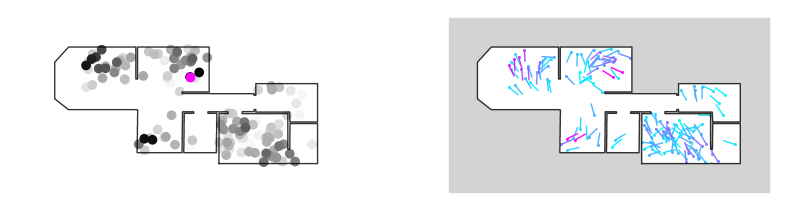

In [35]:
perm = sortperm(ws)
q = quantile(ws, 0.9)
above = q .<= ws


cs = clamp.(ws, q, 0)
cs .-= min(cs...)
cs ./= max(cs...)

fig, axs = plt.subplots(1,2,figsize=(10,6)); 

axs[1].set_aspect(1.); axs[1].axis("off");
draw_env!(env; ax=axs[1], 
    alpha=0.8, zorder=10, wall="black", floor="w", grass="w");
axs[1].scatter(xs[perm,1], xs[perm,2], c=cs[perm], marker="o", alpha=1., cmap="binary", zorder=2)  
axs[1].scatter(xs[perm[end],:]..., c="magenta", marker="o",  alpha=1., linewidth=1, zorder=3)    

    

axs[2].set_aspect(1.); axs[2].axis("off");
draw_env!(env; ax=axs[2], 
        alpha=0.8, zorder=10, wall="black", floor="w", grass="lightgray");
for i in perm
    if !above[i]
        continue
    end
    axs[2].plot([xs[i,1];(xs + 0.8.*vs)[i,1]],[xs[i,2];(xs + 0.8.*vs)[i,2]], c=cm(cs[i]), zorder=5, linewidth=1) ;
    axs[2].scatter(xs[i,:]..., c=[cm(cs[i])], marker=".", s=5, zorder=4);
end
